# Tempo, beat, and downbeat estimation with a Temporal Convolutional Network

The implementation is mainly based on the ISMIR2021 tutorial [Tempo, Beat, and Downbeat Estimation](https://tempobeatdownbeat.github.io/tutorial/intro.html).

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.utils import weight_norm

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import torchaudio

import mirdata
import librosa
import librosa.display
import tqdm

import matplotlib.pyplot as plt
import mir_eval.sonify as sonify
import mir_eval.display as display

SR = 44100
FRAME_SIZE = 441

pl.seed_everything(1234)

print(f'PyTorch: {torch.__version__}')
print(f'Torchaudio: {torchaudio.__version__}')
print(f'PyTorch Lightning: {pl.__version__}')
print(f'librosa: {librosa.__version__}')
print(f'mirdata: {mirdata.__version__}')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Global seed set to 1234


PyTorch: 1.12.0
Torchaudio: 0.12.0
PyTorch Lightning: 1.6.5
librosa: 0.9.2
mirdata: 0.3.6


## Dataset
Load Guitarset with **mirdata** package. Note that the beat/downbeat labels are 'widened' on the preprocessing stage using the `widen_target()` function.

In [2]:
from scipy.ndimage import maximum_filter1d

def widen_target(t, size=5, value=0.5):
    return np.maximum(t, maximum_filter1d(t, size)*value)

def time_to_target(time, length):
    target = np.zeros(length)
    frame_idx = np.round(time * SR // FRAME_SIZE).astype(int)
    frame_idx = frame_idx[frame_idx < length]
    target[frame_idx] = 1.0
    return widen_target(target)

class BeatDownbeatDataset(data.Dataset):
    def __init__(self):
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR,
            n_fft=2048,
            win_length=2048,
            hop_length=FRAME_SIZE,
            n_mels=81,
            power=1,
        )
        self.audio_list = []
        self.spectrogram_list = []
        self.beat_pos_list = []
        self.beat_lab_list = []
        self.downbeat_pos_list = []
        self.downbeat_lab_list = []
        self.tempo_list = []

    def __len__(self):
        return len(self.audio_list)
        
    def __getitem__(self, i):
        audio = self.audio_list[i]
        spec = self.spectrogram_list[i]
        beat_pos = self.beat_pos_list[i]
        beat_lab = self.beat_lab_list[i]
        downbeat_pos = self.downbeat_pos_list[i]
        downbeat_lab = self.downbeat_lab_list[i]
        tempo = self.tempo_list[i]
        return audio, spec, beat_pos, downbeat_pos, beat_lab, downbeat_lab, tempo

class Guitarset(BeatDownbeatDataset):
    def __init__(self):
        super().__init__()
        guitarset = mirdata.initialize('guitarset',data_home='./mirdata/guitarset',version='default')
        guitarset.download(partial_download=['annotations','audio_mic'])    # Download Guitarset if not available
        guitarset_data = guitarset.load_tracks()
        for tid in tqdm.tqdm(guitarset.track_ids, desc="Loading dataset:"):
            track = guitarset_data[tid]
            audio, sr = track.audio_mic
            assert sr==SR
            audio = audio[None, :]
            spectrogram = self.melspec(torch.from_numpy(audio))
            beats_time = track.beats.times
            positions = track.beats.positions
            downbeats_time = beats_time[positions==1]
            tempo = round(track.tempo)
            target_beats = time_to_target(beats_time, length=spectrogram.shape[-1])
            target_downbeats = time_to_target(downbeats_time, length=spectrogram.shape[-1])

            self.audio_list.append(audio)
            self.spectrogram_list.append(spectrogram)
            self.beat_pos_list.append(beats_time)
            self.beat_lab_list.append(torch.from_numpy(target_beats).float())
            self.downbeat_pos_list.append(downbeats_time)
            self.downbeat_lab_list.append(torch.from_numpy(target_downbeats).float())
            self.tempo_list.append(tempo)


Load the dataset and visualize an example of audio and annotations.

INFO: Downloading ['annotations', 'audio_mic'] to ./mirdata/guitarset
INFO: [annotations] downloading annotation.zip
INFO: ./mirdata/guitarset/annotation/annotation.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [audio_mic] downloading audio_mono-mic.zip
INFO: ./mirdata/guitarset/audio_mono-mic/audio_mono-mic.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
Loading dataset:: 100%|██████████| 360/360 [02:54<00:00,  2.06it/s]


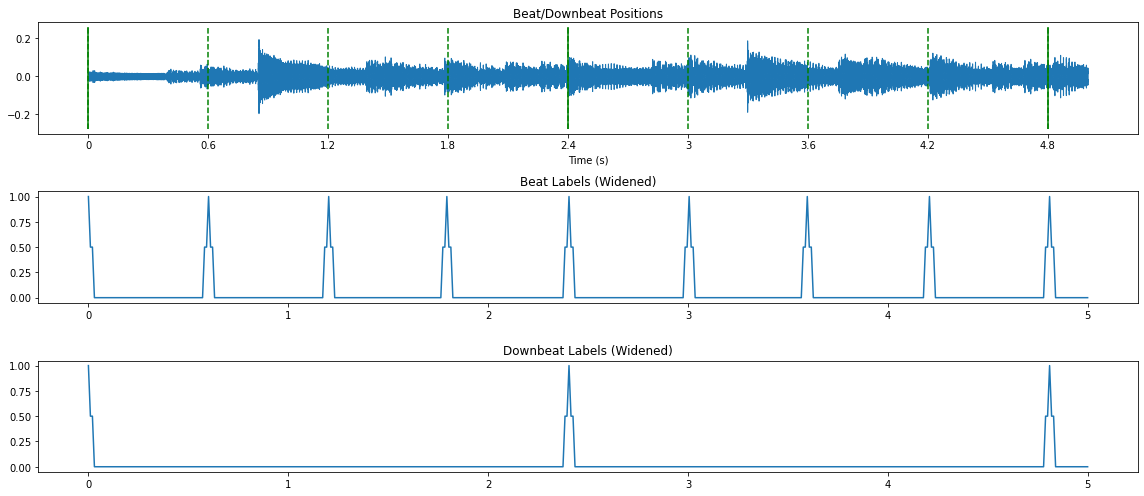

In [3]:
guitarset = Guitarset()

# Split into train/test sets
train_dataset, test_dataset = data.random_split(guitarset, [len(guitarset)-10, 10])

audio, spec, beat_pos, downbeat_pos, t_beat, t_downbeat, t_tempo = test_dataset[0]

# Visualize an example
plt.figure(figsize=(16,7))
plt.subplot(3, 1, 1)
plt.title('Beat/Downbeat Positions')
librosa.display.waveshow(audio[0,:SR*5], sr=SR, x_axis='s')
display.events(beat_pos[beat_pos<5], 
               base=audio.min(), 
               height=(audio.max()-audio.min()), 
               color='green', 
               linestyle='dashed')
display.events(downbeat_pos[downbeat_pos<5], 
               base=audio.min(), 
               height=(audio.max()-audio.min()), 
               color='green', 
               linestyle='solid')
plt.subplot(3, 1, 2)
plt.title('Beat Labels (Widened)')
arr_time = np.linspace(0,5,SR*5//FRAME_SIZE)
plt.plot(arr_time, t_beat[:SR*5//FRAME_SIZE])
plt.subplot(3, 1, 3)
plt.title('Downbeat Labels (Widened)')
plt.plot(arr_time, t_downbeat[:SR*5//FRAME_SIZE])
plt.tight_layout()

## Multi-task Temporal Convolutional Network

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size, dilation, dropout_rate=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.dil_conv1 = weight_norm(nn.Conv1d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=kernel_size,
            padding='same',
            dilation=dilation
        ))
        self.dil_conv2 = weight_norm(nn.Conv1d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=kernel_size,
            padding='same',
            dilation=dilation*2
        ))
        self.conv_out = weight_norm(nn.Conv1d(
            in_channels=channels*2,
            out_channels=channels,
            kernel_size=1
        ))
        self.conv_residual = weight_norm(nn.Conv1d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=1
        ))

    def forward(self, x: torch.Tensor):
        h1, h2 = self.dil_conv1(x), self.dil_conv2(x)
        h_cat = torch.cat([h1, h2], dim=1)
        h_cat = F.elu(h_cat)
        h_cat = self.dropout(h_cat)
        h_cat = self.conv_out(h_cat)

        h_res = self.conv_residual(x)

        y = h_res + h_cat

        return y, h_cat


class TCN(nn.Module):
    def __init__(
        self,
        num_filters=20,
        kernel_size=5,
        dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
        dropout_rate=0.1
    ):
        super().__init__()
        blocks = [ResidualBlock(num_filters,
                                kernel_size,
                                dilation,
                                dropout_rate)
                  for dilation in dilations]
        self.residual_blocks = nn.ModuleList(blocks)

    def forward(self, x: torch.Tensor):
        skip_connections = []
        for block in self.residual_blocks:
            x, skip_out = block(x)
            skip_connections.append(skip_out)
        x = F.elu(x)
        skip = sum(skip_connections)
        return x, skip


class Multitask_BeatTracker(nn.Module):
    def __init__(
        self,
        num_filters=20,
        num_dilations=11,
        kernel_size=5,
        dropout_rate=0.1
    ):
        super().__init__()
        
        self.conv_in = nn.Sequential(
            weight_norm(nn.Conv2d(1, num_filters, (3, 3), 1, (0, 1))),
            nn.ELU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d((3, 1)),
            weight_norm(nn.Conv2d(num_filters, num_filters, (3, 3), 1, (0, 1))),
            nn.ELU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d((3, 1)),
            weight_norm(nn.Conv2d(num_filters, num_filters, (8, 1))),
            nn.ELU(),
            nn.Dropout(dropout_rate),
        )

        dilations = [2**i for i in range(num_dilations)]
        self.tcn = TCN(
            num_filters=num_filters,
            kernel_size=kernel_size,
            dilations=dilations,
            dropout_rate=dropout_rate
        )

        self.out_beats = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv1d(num_filters,1,1)
        )
        self.out_downbeats = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv1d(num_filters,1,1)
        )
        self.out_tempo = nn.Linear(num_filters, 300)

    def forward(self, x: torch.Tensor):
        x = torch.log(x+1e-5)
        h = self.conv_in(x).squeeze(2)
        tcn_out, skip = self.tcn.forward(h)
        beats = self.out_beats(tcn_out).squeeze(1)
        downbeats = self.out_downbeats(tcn_out).squeeze(1)
        tempo = self.out_tempo(F.adaptive_avg_pool1d(skip, 1).squeeze(-1))

        return beats, downbeats, tempo

## Training loop

In [5]:
import torchmetrics.functional as funcmetrics

class LitBeatTracker(pl.LightningModule):
    def __init__(
        self,
        num_filters=20,
        dropout_rate=0.0
    ):
        super().__init__()
        self.model = Multitask_BeatTracker(
            num_filters=num_filters,
            dropout_rate=dropout_rate
        )

    @torch.no_grad()
    def forward(self, x):
        estim_beat, estim_downbeat, estim_tempo = self.model.forward(x[None, :])
        p_beat = torch.sigmoid(estim_beat)[0,:]
        p_downbeat = torch.sigmoid(estim_downbeat)[0,:]
        p_tempo = torch.softmax(estim_tempo, dim=-1)[0,:]

        return p_beat, p_downbeat, p_tempo

    def training_step(self, batch, batch_idx):
        audio, spec, beat_pos, downbeat_pos, t_beat, t_downbeat, t_tempo = batch
        estim_beat, estim_downbeat, estim_tempo = self.model.forward(spec)
        
        loss_beat = F.binary_cross_entropy_with_logits(estim_beat, t_beat)
        loss_downbeat = F.binary_cross_entropy_with_logits(
            estim_downbeat, t_downbeat)
        loss_tempo = F.cross_entropy(estim_tempo, t_tempo)

        F1_beat = funcmetrics.f1_score(torch.sigmoid(estim_beat), (t_beat>0.5).long())
        F1_downbeat = funcmetrics.f1_score(torch.sigmoid(estim_downbeat), (t_downbeat>0.5).long())

        loss = loss_beat+loss_downbeat+loss_tempo   
        return loss

    def configure_optimizers(self):
        return torch.optim.RAdam(self.parameters())

In [6]:
train_dataloader = data.DataLoader(
    dataset = train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

model = LitBeatTracker(
    num_filters=50,
    dropout_rate=0.0
)

trainer = pl.Trainer(
    logger = False,
    gpus=1,
    max_epochs=200,
    enable_checkpointing=False
)

trainer.fit(model, train_dataloader)

INFO: Created a temporary directory at /tmp/tmp6n98ej_o
INFO: Writing /tmp/tmp6n98ej_o/_remote_module_non_scriptable.py
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | Multitask_BeatTracker | 420 K 
------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.682     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Estimate beats and downbeats

In [7]:
# Take an exaple from the test set
audio, spec, beat_pos, downbeat_pos, t_beat, t_downbeat, t_tempo = test_dataset[0]

# Estimate the likelihoods using DNN
model.eval()
prob_beat, prob_downbeat, prob_tempo = model.forward(spec)  

prob_beat = prob_beat.cpu().numpy()
prob_downbeat = prob_downbeat.cpu().numpy()


Let's visualize the results.

In [8]:
print(f'Estimated Tempo: {prob_tempo.argmax()} (Confidence: {prob_tempo.max()*100}% | Ground truth: {t_tempo})')

Estimated Tempo: 100 (Confidence: 99.77735900878906% | Ground truth: 100)


The estimated tempo is correct.

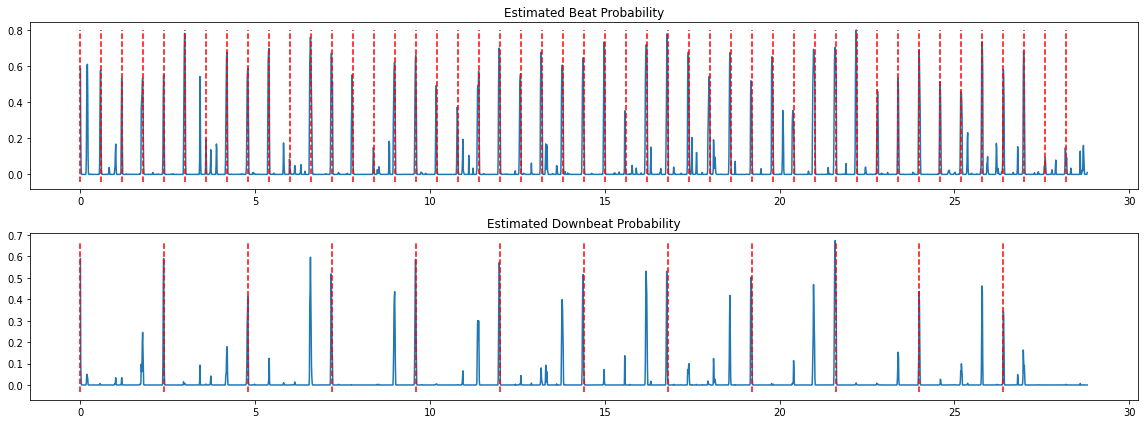

In [9]:
arr_time_seconds = np.linspace(0, audio.shape[-1]/SR, prob_beat.shape[0])
plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)
plt.title('Estimated Beat Probability')
plt.plot(arr_time_seconds, prob_beat)
display.events(beat_pos, color='red', linestyle='dashed')
plt.subplot(2, 1, 2)
plt.title('Estimated Downbeat Probability')
plt.plot(arr_time_seconds, prob_downbeat)
display.events(downbeat_pos, color='red', linestyle='dashed')
plt.tight_layout()

The blue line is the estimated likelihood and the red dashed lines are the ground-truths. There are quite a number of incorrect peaks, so proper post-processing is needed to find the actual beat positions. 

In [10]:
from math import floor, ceil

class StateSpaceModel:
    def __init__(self, min_bpm=80, max_bpm=160):
        # Convert BPM into frame numbers per beat
        assert min_bpm < max_bpm
        nstates_low = floor(60.0 / max_bpm / FRAME_SIZE * SR)
        nstates_high = ceil(60.0 / min_bpm / FRAME_SIZE * SR)
        n_states_per_beat = np.arange(nstates_low, nstates_high)
        assert len(n_states_per_beat) > 1
        list_bpm = 60.0 / (FRAME_SIZE / SR * n_states_per_beat)
        n_tempo = len(n_states_per_beat)
        n_beat_states = n_states_per_beat.sum()
        
        # idx_beat_states: the beat position (=zero-phase) state
        idx_beat_states = [0]
        for i in range(1, len(list_bpm)):
            idx_beat_states.append(idx_beat_states[i-1]+n_states_per_beat[i-1])
        idx_beat_states = np.array(idx_beat_states)

        # Create the transtion probability matrix for beat states
        mat_transition_beat = np.zeros((n_beat_states, n_beat_states), dtype=float)
        for i in range(n_beat_states):
            # Stochastically transit to a zero-phase state if current state is the last phase.
            if (i in (idx_beat_states-1)) or (i == (n_beat_states-1)):
                if i == (n_beat_states-1):
                    cur_tempo = n_tempo-1
                else:
                    cur_tempo = np.where(idx_beat_states == i+1)[0][0] - 1

                # High transition probability towards the zero-phase state of the current tempo, 
                # and low transition probability towards zero-phase states of adjacent tempos.
                mat_transition_beat[i, idx_beat_states] = np.exp(-5*np.abs(list_bpm/list_bpm[cur_tempo]-1))
                mat_transition_beat[i, :] = mat_transition_beat[i, :] / mat_transition_beat[i, :].sum()

            # Transit to the next phase if current state is not the last phase.
            else:
                mat_transition_beat[i, i+1] = 1.0
        self.transition_mat_beat = mat_transition_beat
        self.idx_beat_states = idx_beat_states
        
        # Create the transtion probability matrix for downbeat states
        # Just hard-code the probabilities, since it has only 7 states (representing 3 beats/4 beats per bar)
        mat_transition_downbeat = np.zeros((7, 7), dtype = float)
        mat_transition_downbeat[np.arange(6), np.arange(6)+1]= 1.0

        mat_transition_downbeat[2, 0] = 0.95
        mat_transition_downbeat[2, 3] = 0.05
        mat_transition_downbeat[6, 3] = 0.95
        mat_transition_downbeat[6, 0] = 0.05

        self.n_beat_states = n_beat_states
        self.idx_beat_states = idx_beat_states
        self.idx_non_beat_states = np.setdiff1d(np.arange(n_beat_states), idx_beat_states)
        self.transition_mat_downbeat = mat_transition_downbeat
        self.idx_downbeat_states = np.array([0,3])
        self.idx_non_downbeat_states = np.array([1,2,4,5,6])
    
    def infer_beat_downbeat(self, p_beat, p_downbeat):
        p_beat_state = np.zeros((self.n_beat_states, len(p_beat)))
        p_beat_state[self.idx_beat_states, : ] = p_beat[None, :]
        p_beat_state[self.idx_non_beat_states, :] = 1-p_beat[None,:]

        p_downbeat_state = np.zeros((7, len(p_downbeat)))
        p_downbeat_state[self.idx_downbeat_states, :] = p_downbeat[None, :]
        p_downbeat_state[self.idx_non_downbeat_states, :] = 1.0 - p_downbeat[None, :]

        # Viterbi inference
        beat_states = librosa.sequence.viterbi(p_beat_state, self.transition_mat_beat)
        beat_pos = np.array([pos for pos in range(len(beat_states)) if beat_states[pos] in self.idx_beat_states])
        p_downbeat_state = p_downbeat_state[:, beat_pos]

        downbeat_states = librosa.sequence.viterbi(p_downbeat_state, self.transition_mat_downbeat)
        downbeat_pos = np.array([pos for pos in range(len(downbeat_states)) if downbeat_states[pos] in [0,3]])
        downbeat_pos = beat_pos[downbeat_pos]

        return beat_pos, downbeat_pos

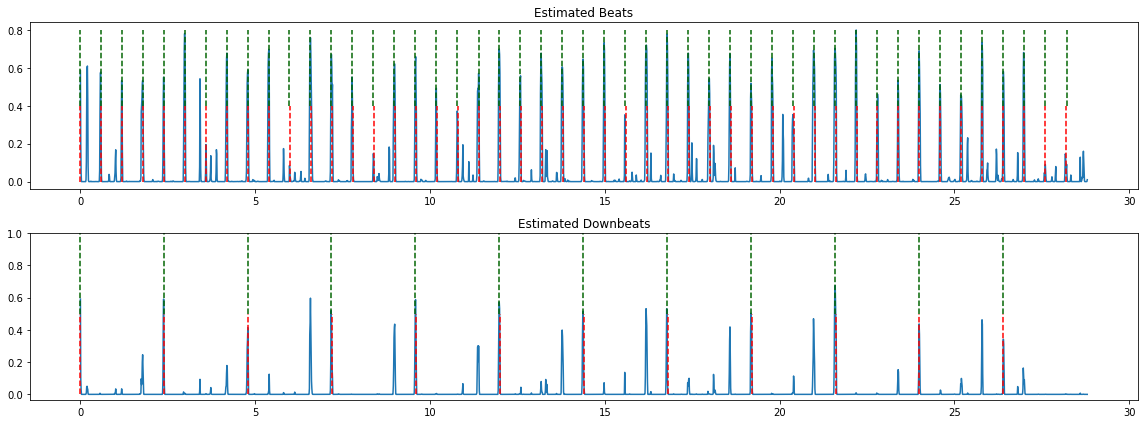

In [11]:
# Limit the tempo range within estimated tempo±20
est_tempo = prob_tempo.argmax()
ssm = StateSpaceModel(min_bpm=est_tempo-20, max_bpm=est_tempo+20)

# Infer beat/downbeat positions
est_beat_pos, est_downbeat_pos = ssm.infer_beat_downbeat(prob_beat, prob_downbeat)
est_beat_pos = est_beat_pos * FRAME_SIZE / float(SR)
est_downbeat_pos = est_downbeat_pos * FRAME_SIZE / float(SR)

# Visualize the post-processing results
plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)
plt.title('Estimated Beats')
plt.plot(arr_time_seconds, prob_beat)
display.events(beat_pos, color='red', linestyle='dashed', base=0.0, height=prob_beat.max()*0.5)
display.events(est_beat_pos, color='darkgreen', linestyle='dashed', base=prob_beat.max()*0.5, height=prob_beat.max()*0.5)
plt.subplot(2, 1, 2)
plt.title('Estimated Downbeats')
plt.plot(arr_time_seconds, prob_downbeat)
display.events(downbeat_pos, color='red', linestyle='dashed', base=0.0, height=0.5)
display.events(est_downbeat_pos, color='darkgreen', linestyle='dashed', base=0.5, height=0.5)
plt.tight_layout()

The green dashed lines are the estimated beat/downbeat positions.